# Test DataGenerator

In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
print(physical_devices)

Num GPUs: 0
[]


In [2]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import albumentations as al

from tensorflow.keras.utils import to_categorical, Sequence

from scripts.labels import labels
from scripts.helper_functions import get_classes, form_2D_label, get_augmented_images
from scripts.generator_old import DataGenerator

### Run DataGenerator

In [3]:
# Parameters
df_train = pd.DataFrame({'xPathLabel': ['/00 data/sample/aachen_000006_000019_leftImg8bit.png', 
                                   '/00 data/sample/aachen_000007_000019_leftImg8bit.png',
                                   '/00 data/sample/aachen_000008_000019_leftImg8bit.png'],                                 
                        'yPathLabel' : ['/00 data/sample/aachen_000006_000019_gtFine_color.png', 
                                    '/00 data/sample/aachen_000007_000019_gtFine_color.png',
                                    '/00 data/sample/aachen_000008_000019_gtFine_color.png']
                        })


data_dir = os.getcwd()
batch_size_min = min(1, len(df_train))

params = {'targetSize': (512,256),
          'batchSize': batch_size_min,
          'augment': 1,
          'nbChannels': 3,
          'shuffle': True}

TRAINSIZE_RATIO = 0.8
SAMPLE_TRAIN = int(df_train.shape[0] * TRAINSIZE_RATIO)

class_labels = get_classes(labels)
trainGen = DataGenerator(data_dir=data_dir,
                         data=df_train,
                         xPathLabel='xPathLabel',
                         yPathLabel='yPathLabel',
                         classes=class_labels,
                         **params)

testGen = DataGenerator(data_dir=data_dir,
                        data=df_train,
                        xPathLabel='xPathLabel',
                        yPathLabel='yPathLabel',
                        classes=class_labels,
                        **params)

# generator checks

In [4]:
x, y = trainGen.__getitem__(0)
x_test, y_test = testGen.__getitem__(0)
xs = trainGen.dataset

In [7]:
xs.batch

<bound method DatasetV2.batch of <PrefetchDataset shapes: ((None, 256, 512, 3), (None, 256, 512, 8)), types: (tf.uint8, tf.uint8)>>

check if generator is recognized as Sequence class

In [5]:
from tensorflow.python.keras.utils.data_utils import Sequence as sq
from tensorflow.keras.utils import Sequence as sq1

print(isinstance(trainGen, sq))
print(isinstance(trainGen, sq1))

print(isinstance(trainGen.dataset, sq))
print(isinstance(trainGen.dataset, sq1))

True
True
False
False


# Test To_Categorical

In [9]:
from PIL import Image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

f_path = './00 data/sample/frankfurt_000000_000294_gtFine_color.png'

y_img = Image.open(f_path).convert('RGB')
y_image = y_img.resize((512,256), resample=Image.NEAREST)
img_array = np.array(y_image)
img_array_2D = form_2D_label(img_array, class_labels[0])
y_cat = to_categorical(img_array_2D, num_classes=len(class_labels[1]))

pd.DataFrame(img_array_2D).to_csv("img2D.csv")

image = tf.io.read_file(f_path)
image = tf.io.decode_png(image, channels=3)
image = tf.image.resize(image, (256,512), 
                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image = image.numpy()
img_array_2D = form_2D_label(image, class_labels[0])
y_cat = to_categorical(img_array_2D, num_classes=len(class_labels[1]))

pd.DataFrame(img_array_2D).to_csv("img2D_1.csv")

In [5]:
image = form_2D_label(image, class_labels[0])
image = to_categorical(image, num_classes=len(class_labels[1]))

image = tf.convert_to_tensor(image, tf.uint8)


# TEST Albumentations

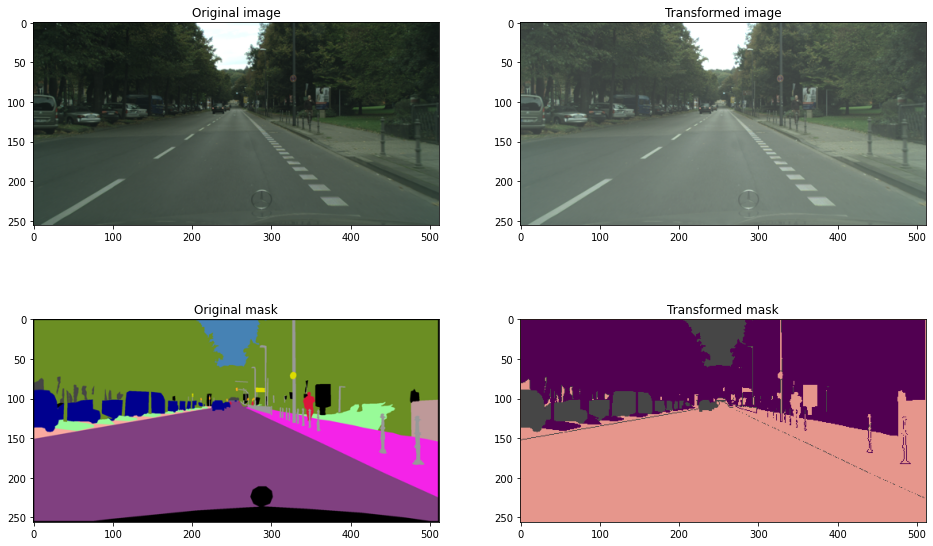

In [9]:
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from scripts.helper_functions import visualize

x_img = Image.open('./00 data/sample/aachen_000006_000019_leftImg8bit.png').convert('RGB')
x_image = x_img.resize((512,256))
x_array = np.array(x_image)

y_img = Image.open('./00 data/sample/aachen_000006_000019_gtFine_color.png').convert('RGB')
y_image = y_img.resize((512,256))
mask_array = np.array(y_image)

transform_pipe = A.Compose([
                A.HorizontalFlip(p=0.75),
                A.RandomBrightnessContrast(p=0.8),
                ])

transformed = transform_pipe(image=x_array, mask=mask_array)

visualize(transformed['image'],transformed['mask'], x_array, mask_array)


# Model Selection

In [4]:
from scripts.model_and_metrics import my_Unet, my_miniUnet, my_testUnet, from_book_model
from scripts.model_and_metrics import DiceLossCls, DiceMetric, IoU, dice_test
import tensorflow.keras as keras

# model = my_Unet(params['targetSize'][1],
#                 params['targetSize'][0], 
#                 nclasses=8, filters=64,
#                 )

# model = my_miniUnet(params['targetSize'][1],
#                 params['targetSize'][0], 
#                 nclasses=8, filters=64,
#                 )

# model = my_testUnet(params['targetSize'][1],
#                 params['targetSize'][0], 
#                 num_classes=8
#                 )

model = from_book_model(8)
'''
The problem is in your target shape and is related to the correct 
choice of an appropriate loss function. you have 2 possibilities:
    1. if you have 1D integer encoded target, 
       you can use 

            "sparse_categorical_crossentropy"

    2. if you have one-hot encoded your target in order to have 
       2D shape (n_samples, n_class), you can use 
       
            "categorical_crossentropy"
'''

model.compile(optimizer="rmsprop",
              loss=DiceLossCls(weight_cross_entropy=True),
              metrics=[DiceMetric(num_classes=8)])

# model.compile(optimizer="rmsprop",
#               loss=DiceLossCls(),
#               metrics=[IoU(num_classes=8)])

# model.compile(optimizer="rmsprop", 
#             loss='mse', 
#             metrics=[tf.keras.metrics.MeanIoU(num_classes=8)])

# model.compile(optimizer="rmsprop",
#               loss=DiceLossCls(),
#               metrics=[dice_test])


# model.compile(optimizer="rmsprop",
#               loss='categorical_crossentropy',
#               metrics=[DiceMetric(num_classes=8)])

# model.summary()

C:\Users\marko\anaconda3\envs\p8Azure\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 512, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 256, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 128)      73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 128, 128)      147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 64, 256)       295168

In [110]:
# for layer in model.layers:
#     print(layer.output_shape)

In [6]:
'''
DO NOT USE mode = 'auto' FOR CUSTOM METRICS
When you build a custom model ModelCheckpoint 
doesn't know if higher or lower value is better, 
so mode='auto' is bad.
'''

monitor_metric = 'val_F1DiceMetric' 
#'val_F1DiceMetric' 'val_IoU', 'val_mean_io_u', 'val_IoU', 'val_dice_test'

callbacks = keras.callbacks.ModelCheckpoint(filepath="outputs/checkpoint", 
                              monitor=monitor_metric, 
                              save_best_only=True,
                              mode = 'max',
                              save_weights_only=True)

EPOCHS = 2
history = model.fit(trainGen.dataset,
                    validation_data=testGen.dataset,
                    # use_multiprocessing=True,
                    # workers=16,
                    callbacks=[callbacks],
                    epochs=EPOCHS,
                    )

Epoch 1/2
3/3 [==============================] - 4s 1s/step - loss: 139.8253 - F1DiceMetric: 0.2919 - val_loss: 1.4623 - val_F1DiceMetric: 0.1281
Epoch 2/2
3/3 [==============================] - 2s 873ms/step - loss: 1.4328 - F1DiceMetric: 0.1935 - val_loss: 1.3591 - val_F1DiceMetric: 0.1600


In [7]:
# get the best model from checkpoints
model.load_weights('outputs/checkpoint')

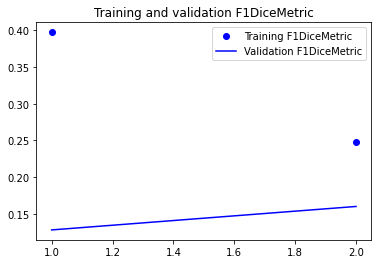

In [8]:
import matplotlib.pyplot as plt

monitor = monitor_metric.split('_')[1]
epochs = range(1, len(history.history[monitor]) + 1)
loss = history.history[monitor]
val_loss = history.history[monitor_metric]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training " + monitor)
plt.plot(epochs, val_loss, "b", label="Validation " + monitor)
plt.title("Training and validation " + monitor)
plt.legend()

In [36]:
model.save("outputs/saved")

INFO:tensorflow:Assets written to: outputs/saved\assets


# Inference Test

In [9]:
from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import array_to_img
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scripts.labels import labels
from scripts.model_and_metrics import dice_loss, DiceLossCls, DiceMetric

from tensorflow.keras.utils import to_categorical
from scripts.helper_functions import label_to_mask, get_classes, form_2D_label


def display_mask(original, pred):
    mask_img = label_to_mask(pred)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1), plt.imshow(original)
    plt.subplot(1, 2, 2), plt.imshow(mask_img)
    plt.tight_layout()
    plt.show()


# custom_metric = DiceMetric(num_classes=8)
# model_path = 'best_model/'
# model = load_model(model_path + '/outputs/best_model/',
#                             custom_objects={'DiceMetric':custom_metric}
#                             )

# model.compile(optimizer="rmsprop", 
#             loss=DiceLossCls(), 
#             metrics=['accuracy', DiceMetric(num_classes=8)],) 

            
x_img = Image.open('./00 data/sample/aachen_000006_000019_leftImg8bit.png').convert('RGB')
x_image = x_img.resize((512,256))
x_array = np.array(x_image)

y_img = Image.open('./00 data/sample/aachen_000006_000019_gtFine_color.png').convert('RGB')
y_image = y_img.resize((512,256))
img_array = np.array(y_image)
img_array_2D = form_2D_label(img_array, class_labels[0])
y_cat = to_categorical(img_array_2D, num_classes=8)

test_image = x_array

mask = model.predict(np.expand_dims(test_image, 0))[0]


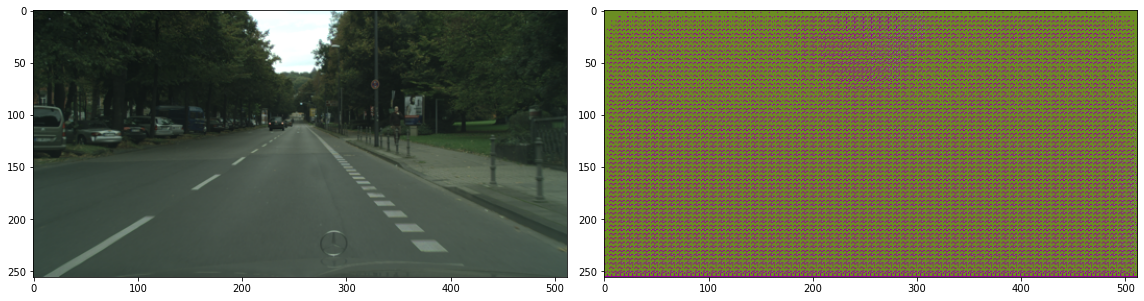

In [10]:
display_mask(test_image, mask)

In [9]:
prediction_1D = tf.reshape(mask, (-1, 8))
y_array_1D = tf.reshape(y_cat, (-1, 8))

def dice_coeff(y_true, y_pred):
    smooth = 1.
    
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)   

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    cardinal = tf.reduce_sum(y_true_f + y_pred_f)

    score = (2. * intersection + smooth) / (cardinal + smooth)

    return score

coef = dice_coeff(prediction_1D, y_array_1D)
tf.print(coef)

0.206641942


In [10]:
print(np.max(prediction_1D),np.max(y_array_1D))
print(np.min(prediction_1D),np.min(y_array_1D))

0.5645663 1.0
0.0003308607 0.0


In [11]:
inter = np.sum(np.multiply(prediction_1D.numpy(), y_array_1D.numpy()))
card = np.sum(prediction_1D.numpy()) + np.sum(y_array_1D.numpy())
print(inter)
print(card)
print(2*inter/card)

27084.576
262144.0
0.20663891732692719


# deserialize numpy to json for api response 

In [1]:
from PIL import Image
import numpy as np
import json
from json import JSONEncoder
import matplotlib.pyplot as plt

mounted_drive = 'C:/Users/marko/Desktop/P8_dataset_small/'
x_img_path = 'images/val/frankfurt_000000_002196_leftImg8bit.png'
x_img = Image.open(mounted_drive + x_img_path).convert('RGB')
x_image = x_img.resize((512,256))
x_array = np.array(x_image)

In [2]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

# Serialization
# x_img = Image.open('image_path.png').convert('RGB')
# x_image = x_img.resize((512,256))
# x_array = np.array(x_image)

numpyData = {"array": x_array}
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)  # use dump() to write array into file
# {"array": [[11, 22, 33], [44, 55, 66], [77, 88, 99]]}

# Deserialization
# print("Decode JSON serialized NumPy array")
decodedArrays = json.loads(encodedNumpyData)
finalNumpyArray = np.asarray(decodedArrays["array"])


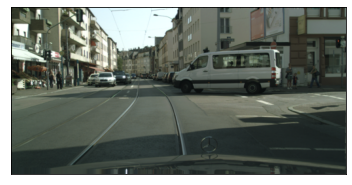

In [3]:
plt.xticks([])
plt.yticks([])
# plt.imshow(x_array)
plt.imshow(finalNumpyArray)


# create parent and child folders

In [12]:
import pathlib
pathlib.Path('azure_deploy/data/images/').mkdir(parents=True, exist_ok=True)